In [1]:
from pathlib import Path

import torch
import albumentations as Aug
import matplotlib.pyplot as plt
import tifffile
from careamics_portfolio import PortfolioManager
from pytorch_lightning import Trainer

from careamics import CAREamicsModule
from careamics.lightning_prediction import CAREamicsFiring
from careamics.ligthning_datamodule import (
    CAREamicsPredictDataModule,
    CAREamicsTrainDataModule,
)
from careamics.transforms import N2VManipulate
from careamics.utils.metrics import psnr

### Import Dataset Portfolio

In [2]:
# Explore portfolio
portfolio = PortfolioManager()
print(portfolio.denoising)

denoising datasets: ['N2V_BSD68', 'N2V_SEM', 'N2V_RGB', 'Flywing', 'Convallaria']


In [3]:
# Download and unzip the files
root_path = Path("data")
files = portfolio.denoising.N2V_BSD68.download(root_path)
print(f"List of downloaded files: {files}")

100%|████████████████████████████████████████| 414M/414M [00:00<00:00, 821GB/s]
Unzipping contents of '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68' to '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip'


List of downloaded files: ['/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/__MACOSX/BSD68_reproducibility_data/._.DS_Store', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/__MACOSX/BSD68_reproducibility_data/test/._.DS_Store', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/.DS_Store', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/.DS_Store', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_25.tiff', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_21.tiff', '/home/ashesh.ashesh/code/careamics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_3.tiff', '/home/ashesh.as

In [4]:
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)
test_path.mkdir(parents=True, exist_ok=True)
gt_path.mkdir(parents=True, exist_ok=True)

### Visualize training data

Train image shape: (180, 180)


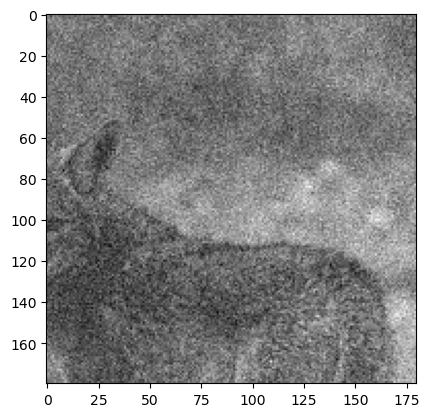

In [5]:
train_image = tifffile.imread(next(iter(train_path.rglob("*.tiff"))))[0]
print(f"Train image shape: {train_image.shape}")
plt.imshow(train_image, cmap="gray")

### Visualize validation data

Validation image shape: (180, 180)


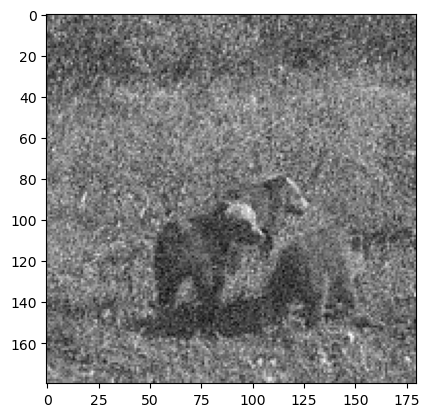

In [6]:
val_image = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))[0]
print(f"Validation image shape: {val_image.shape}")
plt.imshow(val_image, cmap="gray")

### Initialize the Model

Create a Pytorch Lightning module

Please take as look at the [documentation](https://careamics.github.io) to see the full list of parameters and configuration options

In [7]:
model = CAREamicsModule(
    algorithm="n2v",
    loss="n2v",
    architecture="UNet",
    model_parameters={"n2v2": True},
    optimizer_parameters={"lr": 1e-3},
    lr_scheduler_parameters={"factor": 0.5, "patience": 10},
)


### Initialize the datamodule

In [8]:
train_data_module = CAREamicsTrainDataModule(
    train_path=train_path,
    val_path=val_path,
    data_type="tiff",
    patch_size=(64, 64),
    axes="SYX",
    batch_size=128,
    dataloader_params={"num_workers": 4},
)

### Run training 

We need to specify the paths to training and validation data

In [9]:
trainer = Trainer(max_epochs=1, default_root_dir="bsd_test")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/careamics/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.fit(model, datamodule=train_data_module)

Missing logger folder: bsd_test/lightning_logs
Extracted 28512 patches from input array.
Computed dataset mean: 110.72953033447266, std: 63.656009674072266
Extracted 36 patches from input array.

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 343 K 
-------------------------------
343 K     Trainable params
0         Non-trainable params
343 K     Total params
1.372     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/localscratch/miniforge3/envs/careamics/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 223/223 [06:48<00:00,  0.55it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 223/223 [06:48<00:00,  0.55it/s, v_num=0]


### Define a prediction datamodule

In [11]:
pred_data_module = CAREamicsPredictDataModule(
    pred_path=test_path,
    data_type="tiff",
    tile_size=(256, 256),
    axes="YX",
    batch_size=1,
    tta_transforms=True,
)

No transform defined for prediction. Prediction will apply default normalization only.


### Run prediction

We need to specify the path to the data we want to denoise

In [12]:
tiled_loop = CAREamicsFiring(trainer)

In [13]:
trainer.predict_loop = tiled_loop

In [14]:
preds = trainer.predict(model, datamodule=pred_data_module)

Calculated mean and std for 68 images
Mean: 109.97985693987678, std: 58.40851918388815
/localscratch/miniforge3/envs/careamics/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: |          | 408/? [03:39<00:00,  1.86it/s]


### Visualize results and compute metrics


In [15]:
# Create a list of ground truth images

gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]


PSNR for image 0: 27.594791324272244


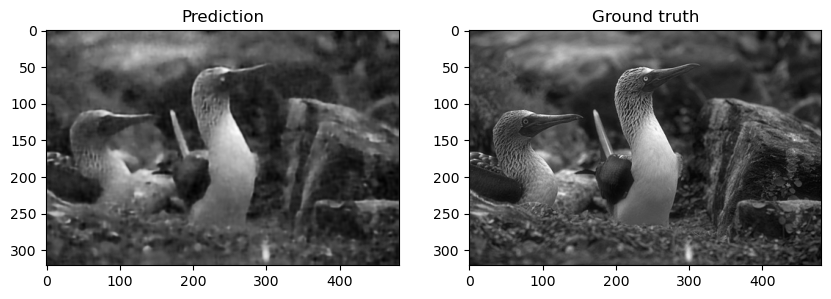

In [16]:
# Plot single image

image_idx = 0
_, subplot = plt.subplots(1, 2, figsize=(10, 10))

subplot[0].imshow(preds[image_idx].squeeze(), cmap="gray")
subplot[0].set_title("Prediction")
subplot[1].imshow(gts[image_idx], cmap="gray")
subplot[1].set_title("Ground truth")


# Calculate PSNR for single image
psnr_single = psnr(preds[image_idx].squeeze(), gts[image_idx].squeeze())
print(f"PSNR for image {image_idx}: {psnr_single}")

Text(0.5, 1.0, 'Ground truth')

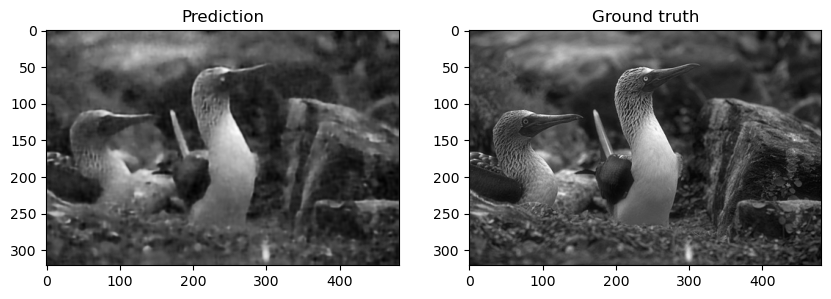

In [17]:
# Plot single image

image_idx = 0
_, subplot = plt.subplots(1, 2, figsize=(10, 10))

subplot[0].imshow(preds[image_idx].squeeze(), cmap="gray")
subplot[0].set_title("Prediction")
subplot[1].imshow(gts[image_idx], cmap="gray")
subplot[1].set_title("Ground truth")

In [18]:
# Calculate PSNR for single image

psnr_single = psnr(gts[image_idx], preds[image_idx].squeeze())
print(f"PSNR for image {image_idx}: {psnr_single}")

PSNR for image 0: 27.594791324272244


In [19]:
psnr_total = 0

for pred, gt in zip(preds, gts):
    psnr_total += psnr(gt, pred.squeeze())

print(f"PSNR total: {psnr_total / len(preds)}")

PSNR total: 24.981925719069388
